Простой бейзлайн для задачи рекомендации товаров https://retailhero.ai/c/recommender_system/overview  
Скор ниже бейзлайна организаторов: 0.081 на валидации и 0.076 на паблике.

Использованная модель неэффективна, т.к. включает только 225 самых популярных товаров и четыре фичи (возраст, пол, товаров в корзине, популярный товар).  
Предполагается, что в докере только CPU. Поэтому используется классификатор без подддержки GPU, он очень долго тренируется.   
Ноутбук просто показывает, как сохранять модель и метки товаров для предсказания в докере. 

In [2]:
import pandas as pd
import numpy as np
import pickle
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.model_selection import train_test_split
import tqdm

In [3]:
purch_list = ['client_id', 'product_id', #'product_quantity', 'purchase_sum', 
              'transaction_datetime', 'transaction_id']
df_clients = pd.read_csv('data/clients.csv')[['client_id', 'age','gender']]
df_purchases = pd.read_csv('data/purchases.csv')[purch_list]
#df_products = pd.read_csv('data/products.csv')

In [3]:
#Количество товаров
df_purchases.product_id.nunique()

42530

In [4]:
#Оставляем только самые популярные товары для упрощенного классификатора (250 наименований из 42 тыс)
top_product = list(df_purchases.product_id[df_purchases.product_id.value_counts(ascending=False)])

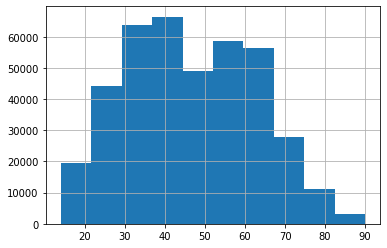

In [5]:
%matplotlib inline
df_clients.age.clip(14, 90).hist()

In [6]:
#удалить или исправить строки с неправильным возрастом
#df_clients.age.clip(14, 90).value_counts(ascending=True)[0:10]
df_clients = df_clients.loc[(df_clients['age'] >= 14) & (df_clients['age'] <= 90)]
df_clients['age'] = df_clients['age'].astype('int8')

In [7]:
df_clients.gender.value_counts(dropna=False)

U    184375
F    147567
M     66351
Name: gender, dtype: int64

In [8]:
#Кодирование пола для модели
df_clients['gender']=df_clients['gender'].map({'U':2, 'F':1, 'M':0}).astype('int8')

Сбор инфо о клиентах и покупках в одну таблицу

In [9]:
X = pd.merge(df_clients, df_purchases, how='left', left_on='client_id', right_on='client_id', left_index=True)
X.head(3)

,client_id,age,gender,product_id,transaction_datetime,transaction_id
0,000012768d,45,2,9a80204f78,2018-12-01 07:12:45,7e3e2e3984
1,000012768d,45,2,da89ebd374,2018-12-01 07:12:45,7e3e2e3984
2,000012768d,45,2,0a95e1151d,2018-12-01 07:12:45,7e3e2e3984


In [10]:
del df_clients, df_purchases

Паблик тестируется по новым клиентам, которых нет в трейне. Поэтому для проверки качества решения выделяем отложенную выборку с новыми клиентами.   
У некоторых клиентов в истории только одна транзакция. Их невозможно разделить на трейн и таргет. Можно удалить таких клиентов. Или можно оставить их, поместив в таргет. 

In [ ]:
#список уникальных клиентов, с более чем 1 транзакцией
#unique_client = []
#temp = X.drop_duplicates(subset=['client_id','transaction_id'], keep='last').client_id.value_counts(dropna=False)

#for client_id in temp.index:
#    if temp[client_id] > 1:
        #print (c)
#        unique_client.append(client_id)

## Разделение данных на у и Х

Таргетом будет самая последняя по времени транзакция клиента. Нам нужен список входящих в нее продуктов. Если не удаляли клиентов только с 1 транзакцией, то некоторые клиенту попадут только в таргет, по трейну у них будут пропуски, которые надо заполнить.

In [11]:
X.sort_values("transaction_datetime", inplace=True)
X.reset_index(drop=True, inplace=True)
#train.dropna(inplace=True)

In [12]:
#Список последних транзакций для каждого клиента
y_last = X.drop_duplicates(subset=['client_id'], keep='last').transaction_id.unique().tolist()

При проверке решений на сайте конкурса подается id клиента, список id купленных товаров и purchase_sum
В 'у' будут колонки 'client_id', 'product_id'. Создаем общий датафрейм, начиная с у, и присоединяя к нему фичи.

In [13]:
#Первые фичи 'age', 'gender' добавляем в df одновременно с таргетом
df = X[['client_id', 'product_id', 'age', 'gender']].loc[X['transaction_id'].isin(y_last)] 

In [14]:
#заменяем X на новый уже без последней транзакции
#Х датафрейм, из которого мы будем извлекать фичи для df.
X = X.loc[~X['transaction_id'].isin(y_last)]
#удаляем лишние колонки
X.drop(['transaction_datetime',], axis=1, inplace=True)

## Новые фичи

Добавим самый часто покупаемый продукт

In [ ]:
#можно считать по 'product_quantity', но с ней какие-то проблемы на паблике
#temp = X[['client_id', 'product_id', 'product_quantity']].groupby(['client_id', 'product_id',]).sum()
#через моду
#temp = X[['client_id', 'product_id']].groupby(['client_id']).agg(lambda x: pd.Series.mode(x)[0])
#temp.reset_index(drop=False, inplace=True)
#temp.rename(columns={'product_id': 'popular_product',}, inplace=True)

In [15]:
#через .count()
temp = X[['client_id', 'product_id', 'transaction_id']].groupby(['client_id', 'product_id',]).count()
temp.sort_values("transaction_id", ascending=False, inplace=True)
temp.reset_index(drop=False, inplace=True)
temp.rename(columns={'product_id': 'popular_product',}, inplace=True)
temp.drop_duplicates(subset= ['client_id'], keep = "first", inplace=True)
temp.head(3)

,client_id,popular_product,transaction_id
0,56ddb01c2f,304df03bb3,226
1,085b23ad91,ea27d5dc75,206
3,876124a2e2,4009f09b04,178


In [16]:
df = pd.merge(df, temp[['client_id', 'popular_product']], how='left', left_on='client_id', right_on='client_id', left_index=True)
df['popular_product'] = df['popular_product'].astype(str)
df.shape

(2510520, 5)

In [17]:
#закодируем популярные товары для классификатора
prod_enc = LabelEncoder()
df['popular_product'] = prod_enc.fit_transform(df.popular_product)

In [18]:
#Сохраняем метки
#По тренировочным данным проблем не будет, на паблике/привате возможно появление новых товаров
joblib.dump(prod_enc, 'prod_enc.pkl') 
#загрузка
#prod_enc = joblib.load('prod_enc.pkl') 

['prod_enc.pkl']

Список продуктов, купленных ранее

In [19]:
#Все продукты в строку
temp = X[['client_id', 'product_id']].groupby('client_id').agg({'product_id':lambda x: ' '.join(map(str, x))})
temp.columns = ['product_past']
temp.reset_index(drop=False, inplace=True)
temp.head(3)

,client_id,product_past
0,000012768d,9a80204f78 63e2eac70d c55ed13ebd 7118c66f7f ad...
1,000036f903,f6ad31e071 40ca9f958b ec58749ad9 746d395a83 d5...
2,000048b7a6,560859ac58 b4c4176fc2 981f5e9cd5 9ccb0013a6 4a...


In [20]:
df = pd.merge(df, temp[['client_id', 'product_past']], how='left', left_on='client_id', right_on='client_id', left_index=True)

Добавим среднее количество наименований продуктов в транзакции

In [21]:
%%time
temp = X[['client_id', 'transaction_id', 'product_id']].groupby(['client_id']).nunique()
temp['product_len'] = (temp['product_id']//temp['transaction_id']).astype('int8')
temp.drop(['client_id'], axis=1, inplace=True)
temp.reset_index(drop=False, inplace=True)
temp.head(3)

CPU times: user 4min 39s, sys: 2.15 s, total: 4min 41s
Wall time: 4min 41s


,client_id,transaction_id,product_id,product_len
0,000012768d,3,44,14
1,000036f903,31,94,3
2,000048b7a6,7,43,6


In [22]:
df = pd.merge(df, temp[['client_id', 'product_len']], how='left', left_on='client_id', right_on='client_id', left_index=True)

Среднее количество штук продуктов и среднюю сумму по транзакции

In [ ]:
#temp = X[['client_id', 'product_quantity', 'purchase_sum']].groupby(['client_id']).mean().round(2)
#temp.rename(columns={'product_quantity': 'quantity_mean','purchase_sum': 'sum_mean',}, inplace=True)
#temp.reset_index(drop=False, inplace=True)
#df = pd.merge(df, temp[['client_id', 'quantity_mean', 'sum_mean']], how='left', left_on='client_id', right_on='client_id', left_index=True)

In [23]:
del temp

In [24]:
df.head(3)

,client_id,product_id,age,gender,popular_product,product_past,product_len
86039,3881df0db9,0790631182,42,2,12633,29cc958e83 bc55423f1f 23e50d7ba4 80484b7610 7e...,2.0
368439,f18e52be4c,5c6f164859,48,1,442,04ef82a636 22c17a4a7f da16147964 134f3dd62d 05...,4.0
368439,f18e52be4c,1222d52eb9,48,1,442,04ef82a636 22c17a4a7f da16147964 134f3dd62d 05...,4.0


## Подготовка датафрейма для тренировки

Разделение датафрейма на тренировочную, валидационную и отложенную выборки

In [25]:
#список уникальных клиентов
unique_client = df.client_id.unique().tolist()
#В отложенную выбору около 10 000 клиентов
client_train, client_hold = train_test_split(unique_client, test_size=0.03, random_state=42, 
                                             shuffle=True)
client_train, client_valid = train_test_split(client_train, test_size=0.3, random_state=42, 
                                              shuffle=True)

In [27]:
#Отделяем отложенную выборку от тренировочной и валидационной до удаления таргетов.
#В отложенной выборке будут все товары
df_hold = df.loc[X['client_id'].isin(client_hold)] 

In [28]:
#Решаем, сколько таргетов оставить для модели классификации
#В трейне и валидации будет сокращенное число у
df = df.loc[df['product_id'].isin(top_product[0:250])] 
df['product_id'].nunique()

222

In [29]:
#Уже сокращенную выборку делим на тренировчную и валидационную
df_train = df.loc[X['client_id'].isin(client_train)] 
df_valid = df.loc[X['client_id'].isin(client_valid)] 

In [30]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 344644 entries, 86749 to 246882
Data columns (total 7 columns):
client_id          344644 non-null object
product_id         344644 non-null object
age                344644 non-null int8
gender             344644 non-null int8
popular_product    344644 non-null int64
product_past       331836 non-null object
product_len        331836 non-null float64
dtypes: float64(1), int64(1), int8(2), object(3)
memory usage: 16.4+ MB


In [ ]:
#Удяляем клиентов без истории, если не удалили раньше
df_train.dropna(inplace=True)
df_valid.dropna(inplace=True)

In [32]:
df_train.head(3)

,client_id,product_id,age,gender,popular_product,product_past,product_len
86749,38f96ca81e,f4599ca21a,43,0,2514,dc2a63ce2b 2a9cadfc04 31dcf71bbd 439498bce2 40...,4.0
86749,38f96ca81e,439498bce2,43,0,2514,dc2a63ce2b 2a9cadfc04 31dcf71bbd 439498bce2 40...,4.0
156686,66e6b7a01f,4009f09b04,45,0,4345,fc5b0d84e8 1c8164db4d 35fdf97254 113e3ace79 dc...,6.0


In [33]:
#Если в валидационной выборке будут продукты, не встреченные раньше, то тренировка прервется
lost = list(set(df_valid['product_id']) - set(df_train['product_id']))
print(lost)

[]


In [34]:
# удаляем lost
df_valid = df_valid.loc[~df_valid['product_id'].isin(lost)]

Используем LabelEncoder для меток товаров

In [35]:
#Подразумевается, что мы не будем пытаться предскзывать новые товары
le = LabelEncoder()
#Кодировать только после удаления всего лишнего
y_train = le.fit_transform(df_train['product_id'])
y_valid = le.transform(df_valid['product_id'])
#le.inverse_transform(y_pred)

In [36]:
#проверка
le.transform(['4009f09b04'])

array([65])

In [37]:
#Сохраняем метки
joblib.dump(le, 'le.pkl') 
#загрузка
#le = joblib.load('le.pkl') 

['le.pkl']

Список фич для модели

In [38]:
feature = ['age', 'gender', 'popular_product', 'product_len']
cat_features = ['gender', 'popular_product', ]

## Подготовка отложенной выборки

In [41]:
y_hold = df_hold.groupby("client_id")['product_id'].agg(lambda x: x.tolist())
y_hold = pd.DataFrame(y_hold)
y_hold.columns = ['product_ids']
y_hold.reset_index(drop=False, inplace=True)

In [42]:
#hold = hold['client_id' + feature].groupby(['client_id']).first()
hold = df_hold[['client_id', 'age', 'gender', 'popular_product', 'product_len']].groupby(['client_id']).first()

In [43]:
# заново используем df_hold для результата
df_hold = pd.merge(y_hold, hold, how='left', left_on='client_id', right_on='client_id', left_index=True)
df_hold.reset_index(drop=True, inplace=True)
df_hold.head(3)

,client_id,product_ids,age,gender,popular_product,product_len
0,0034f7f469,[5cb93c9bc5],71,1,15465,1.0
1,00350b2a7c,"[15339081cb, 976eed29d2, b692cb34b0, 53fc95e17...",34,2,1054,1.0
2,00350e1366,"[5cb93c9bc5, ac81544ebc, 2e7d93664f, 4dcf79043...",61,1,14849,3.0


In [44]:
#Для проверки решения обращаться к у построчно по 'client_id'
y_hold['product_ids'][y_hold.client_id == "00350b2a7c"]

1    [15339081cb, 976eed29d2, b692cb34b0, 53fc95e17...
Name: product_ids, dtype: object

In [45]:
del y_hold, hold

In [46]:
#При проверке пропуски будут проблемой
df_hold.dropna(inplace=True)
df_hold.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11881 entries, 0 to 11880
Data columns (total 6 columns):
client_id          11881 non-null object
product_ids        11881 non-null object
age                11881 non-null int8
gender             11881 non-null int8
popular_product    11881 non-null int64
product_len        11881 non-null float64
dtypes: float64(1), int64(1), int8(2), object(2)
memory usage: 487.3+ KB


## Тренировка простой модели

In [64]:
#классификатор не подходит для этой задачи
classifier = LGBMClassifier(objective = 'multiclass', num_leaves=4, n_estimators=100, random_state=42,
                           subsample_freq=1, subsample=0.75, colsample_bytree=0.9, learning_rate=0.05)

In [65]:
%%time
classifier.fit(df_train[feature], df_train['product_id'], eval_set=[(df_valid[feature], df_valid['product_id'])], 
                early_stopping_rounds=5, verbose=5, categorical_feature = cat_features)

Training until validation scores don't improve for 5 rounds.
[5]	valid_0's multi_logloss: 3.75992
[10]	valid_0's multi_logloss: 3.73842
[15]	valid_0's multi_logloss: 3.72191
[20]	valid_0's multi_logloss: 3.71131
[25]	valid_0's multi_logloss: 3.70106
[30]	valid_0's multi_logloss: 3.69427
[35]	valid_0's multi_logloss: 3.68905
[40]	valid_0's multi_logloss: 3.68627
[45]	valid_0's multi_logloss: 3.68345
[50]	valid_0's multi_logloss: 3.68093
[55]	valid_0's multi_logloss: 3.67936
[60]	valid_0's multi_logloss: 3.67872
[65]	valid_0's multi_logloss: 3.67747
[70]	valid_0's multi_logloss: 3.6768
[75]	valid_0's multi_logloss: 3.67668
[80]	valid_0's multi_logloss: 3.67664
[85]	valid_0's multi_logloss: 3.67679
Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 3.67664
CPU times: user 9min 21s, sys: 1.03 s, total: 9min 22s
Wall time: 2min 26s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=4,
               objective='multiclass', random_state=42, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=0.75,
               subsample_for_bin=200000, subsample_freq=1)

In [66]:
#Сохранение модели
joblib.dump(classifier, 'classifier.pkl') 
#загрузка
#classifier = joblib.load('classifier.pkl') 

['classifier.pkl']

Проверка прогнозирования на одном примере

In [67]:
classifier.predict(df_train[feature].head(1))

array(['4009f09b04'], dtype=object)

In [68]:
#На сайте запросы поступают по одному
y_pred = classifier.predict_proba(df_train[feature].head(1))
#минус перед y, чтобы сортировка шла по убыванию и можно было n вместо 30 брать
#best_n = np.argsort(y_pred, axis=1)[:,-30:]
best_n = np.argsort(-y_pred, axis=1)[:,0:30]
best_n

array([[ 65,  22,  94, 214,  61,  75,  49,  69, 207,  11, 179,  87, 155,
         10, 110,  18,  47,  27, 198,  85, 105,  14, 174, 213,  98,  81,
        142, 194, 136, 217]])

In [69]:
recommended = list(le.inverse_transform(best_n[0]))
print(recommended)

['4009f09b04', '15ccaa8685', '5cb93c9bc5', 'f4599ca21a', '3e038662c0', '4dcf79043e', '343e841aaa', '439498bce2', 'f098ee2a85', '0a46068efc', 'dc2001d036', '5645789fdf', 'bf07df54e1', '080ace8748', '729d6939be', '113e3ace79', '31dcf71bbd', '1c257c1a1b', 'ea27d5dc75', '53fc95e177', '6d0f84a0ac', '0cbc352942', 'd860464ae1', 'f43c12d228', '647c87e132', '5186e12ff4', 'ac81544ebc', 'e6f8ac5174', 'a02d521260', 'f7724d5786']


### Оценка по отложенной выборке

In [181]:
#старая метрика метрика
#def average_precision(actual, recommended):
#    ap_sum = 0
#    hits = 0
#    for place, product_id in enumerate(recommended):
#        k = place+1
#        if product_id in actual:
#            hits += 1
#            ap_sum += hits / k
    #return ap_sum / min(len(recommended), len(actual))
#    return ap_sum / min(30, len(actual))

In [70]:
def average_precision(actual, recommended, k=30):
    ap_sum = 0
    hits = 0
    for i in range(k):
        product_id = recommended[i] if i < len(recommended) else None
        if product_id is not None and product_id in actual:
            hits += 1
            ap_sum += hits / (i + 1)
    return ap_sum / k


def normalized_average_precision(actual, recommended, k=30):
    actual = set(actual)
    if len(actual) == 0:
        return 0.0
    
    ap = average_precision(actual, recommended, k=k)
    ap_ideal = average_precision(actual, list(actual)[:k], k=k)
    return ap / ap_ideal

In [71]:
%%time
#Строк больше 10 тыс. Это займет некоторое время
client_list = list(df_hold.client_id.unique())
ap_values = []

for client_id in tqdm.tqdm(client_list):
    df = df_hold[df_hold.client_id ==client_id]
    y_pred = classifier.predict_proba(df[feature])#, num_iteration=classifier.best_iteration_
    #n = int(df['product_len'].clip(1, 30))
    n = 30
    recommended = list(le.inverse_transform(np.argsort(-y_pred, axis=1)[:,0:n][0]))
    #ap = average_precision(df['product_ids'].tolist()[0], recommended)
    ap = normalized_average_precision(df['product_ids'].tolist()[0], recommended)
    #print(ap)
    ap_values.append(ap)
map_score = sum(ap_values) / len(ap_values)
print(map_score)

100%|██████████| 11881/11881 [01:38<00:00, 120.49it/s]

0.07191154049866394
CPU times: user 3min 25s, sys: 910 ms, total: 3min 26s
Wall time: 1min 38s


В архив solution.zip необходимо положить следующие файлы:
- metadata.json от организаторов, без изменения,
- server.py основной код для загрузки файлов и предскзаний,
- prod_enc.pkl метки для всех продуктов из трейна,
- le.pkl таргет для этой модели,  
- classifier.pkl сама модель.

Надо учесть, что если будет предсказано 2 одинаковыхз товара, решение крашится